Using device: cuda


/tmp/ipykernel_36/1256562211.py:428: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset('/kaggle/input/pr1-rbc-sim-data/RBC_Output.nc')



RUNNING EXPERIMENT 1: Re-training Rollout

--- Training for target t=45.0s ---
Using history from time indices: [30, 60]
  Epoch 0/1600 | Total Loss: 5857.635254 | Physics: 1.310197 | Data: 584.951965
  Epoch 100/1600 | Total Loss: 3989.220459 | Physics: 1.303445 | Data: 398.108856
  Epoch 200/1600 | Total Loss: 21.496288 | Physics: 1.289133 | Data: 1.583662
  Epoch 300/1600 | Total Loss: 6.360837 | Physics: 1.280411 | Data: 0.093194
  Epoch 400/1600 | Total Loss: 6.032063 | Physics: 1.280836 | Data: 0.060729
  Epoch 500/1600 | Total Loss: 5.881841 | Physics: 1.280237 | Data: 0.045340
  Epoch 600/1600 | Total Loss: 5.843533 | Physics: 1.280337 | Data: 0.041876
  Epoch 700/1600 | Total Loss: 5.813708 | Physics: 1.280329 | Data: 0.039080
  Epoch 800/1600 | Total Loss: 5.790892 | Physics: 1.280278 | Data: 0.036982
  Epoch 900/1600 | Total Loss: 5.913948 | Physics: 1.280751 | Data: 0.049210
  Epoch 1000/1600 | Total Loss: 5.824143 | Physics: 1.280418 | Data: 0.040851
  Epoch 1100/1600 | T

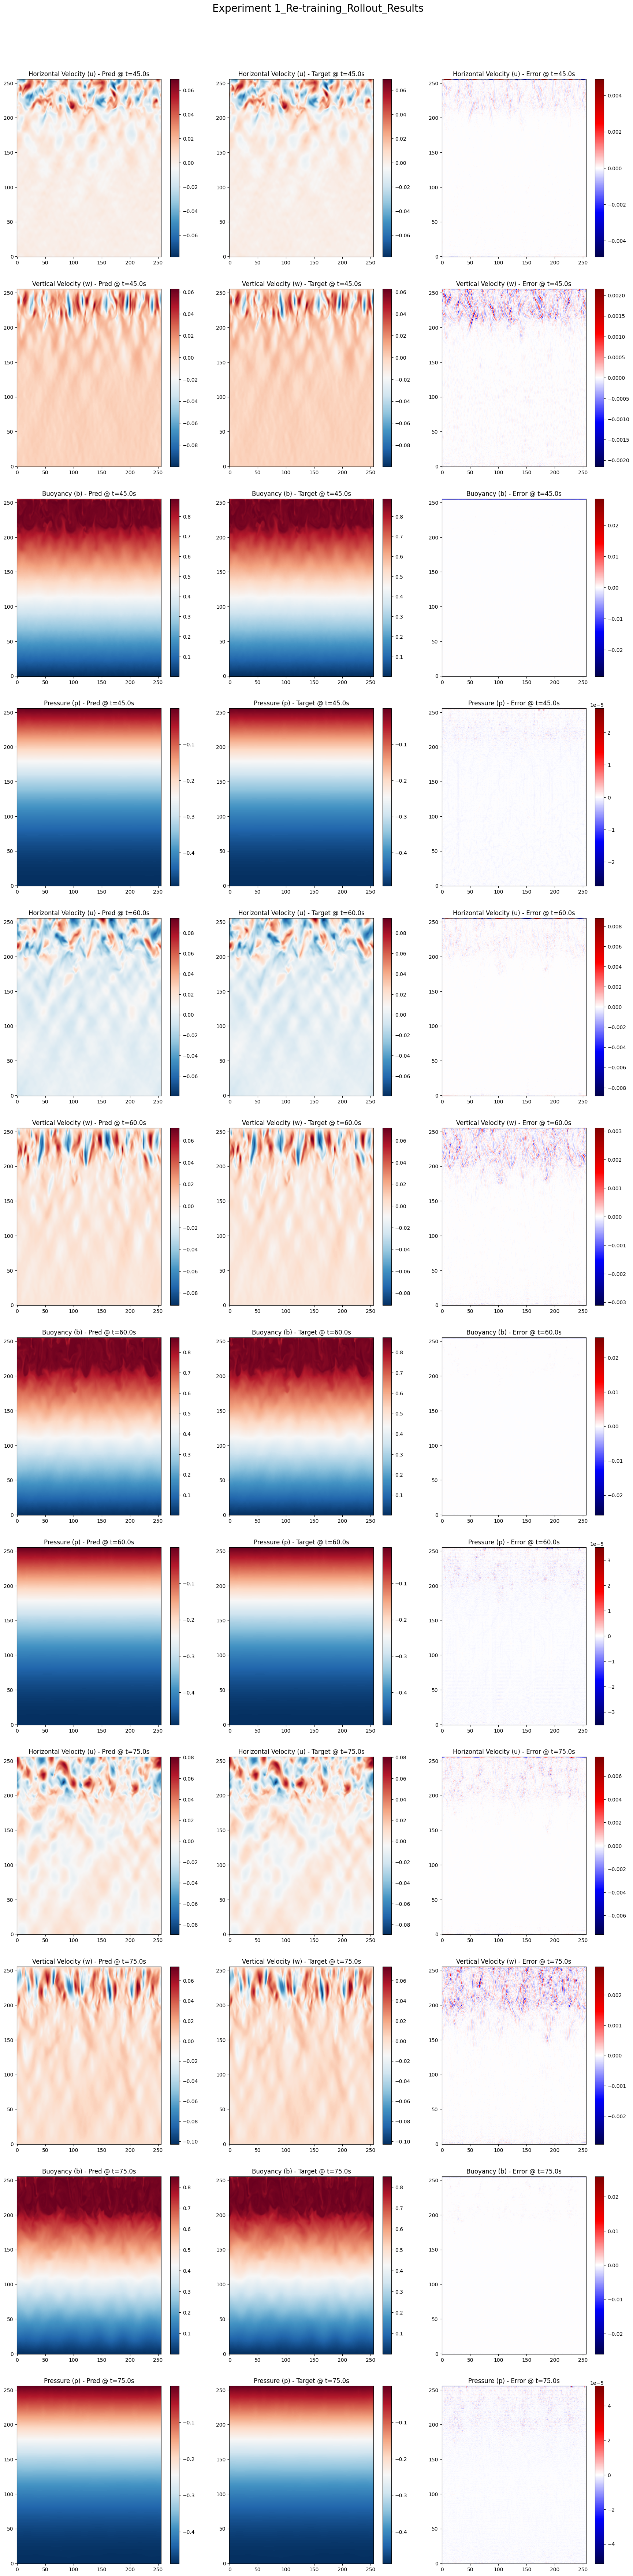


RUNNING EXPERIMENT 2: Autoregressive Rollout
--- Training a single model on time indices: [30, 60] ---
  Epoch 0/1600 | Total Loss: 5904.550781 | Physics: 1.310142 | Data: 589.643677
  Epoch 100/1600 | Total Loss: 4012.008545 | Physics: 1.307966 | Data: 400.389526
  Epoch 200/1600 | Total Loss: 25.798361 | Physics: 1.280382 | Data: 1.999398
  Epoch 300/1600 | Total Loss: 6.575491 | Physics: 1.280291 | Data: 0.114842
  Epoch 400/1600 | Total Loss: 6.140732 | Physics: 1.282403 | Data: 0.071181
  Epoch 500/1600 | Total Loss: 6.183485 | Physics: 1.280367 | Data: 0.077440
  Epoch 600/1600 | Total Loss: 5.960497 | Physics: 1.279546 | Data: 0.055287
  Epoch 700/1600 | Total Loss: 5.908930 | Physics: 1.281036 | Data: 0.050696
  Epoch 800/1600 | Total Loss: 5.806462 | Physics: 1.280913 | Data: 0.039604
  Epoch 900/1600 | Total Loss: 5.788442 | Physics: 1.280324 | Data: 0.037669
  Epoch 1000/1600 | Total Loss: 5.773665 | Physics: 1.280396 | Data: 0.036107
  Epoch 1100/1600 | Total Loss: 5.76864

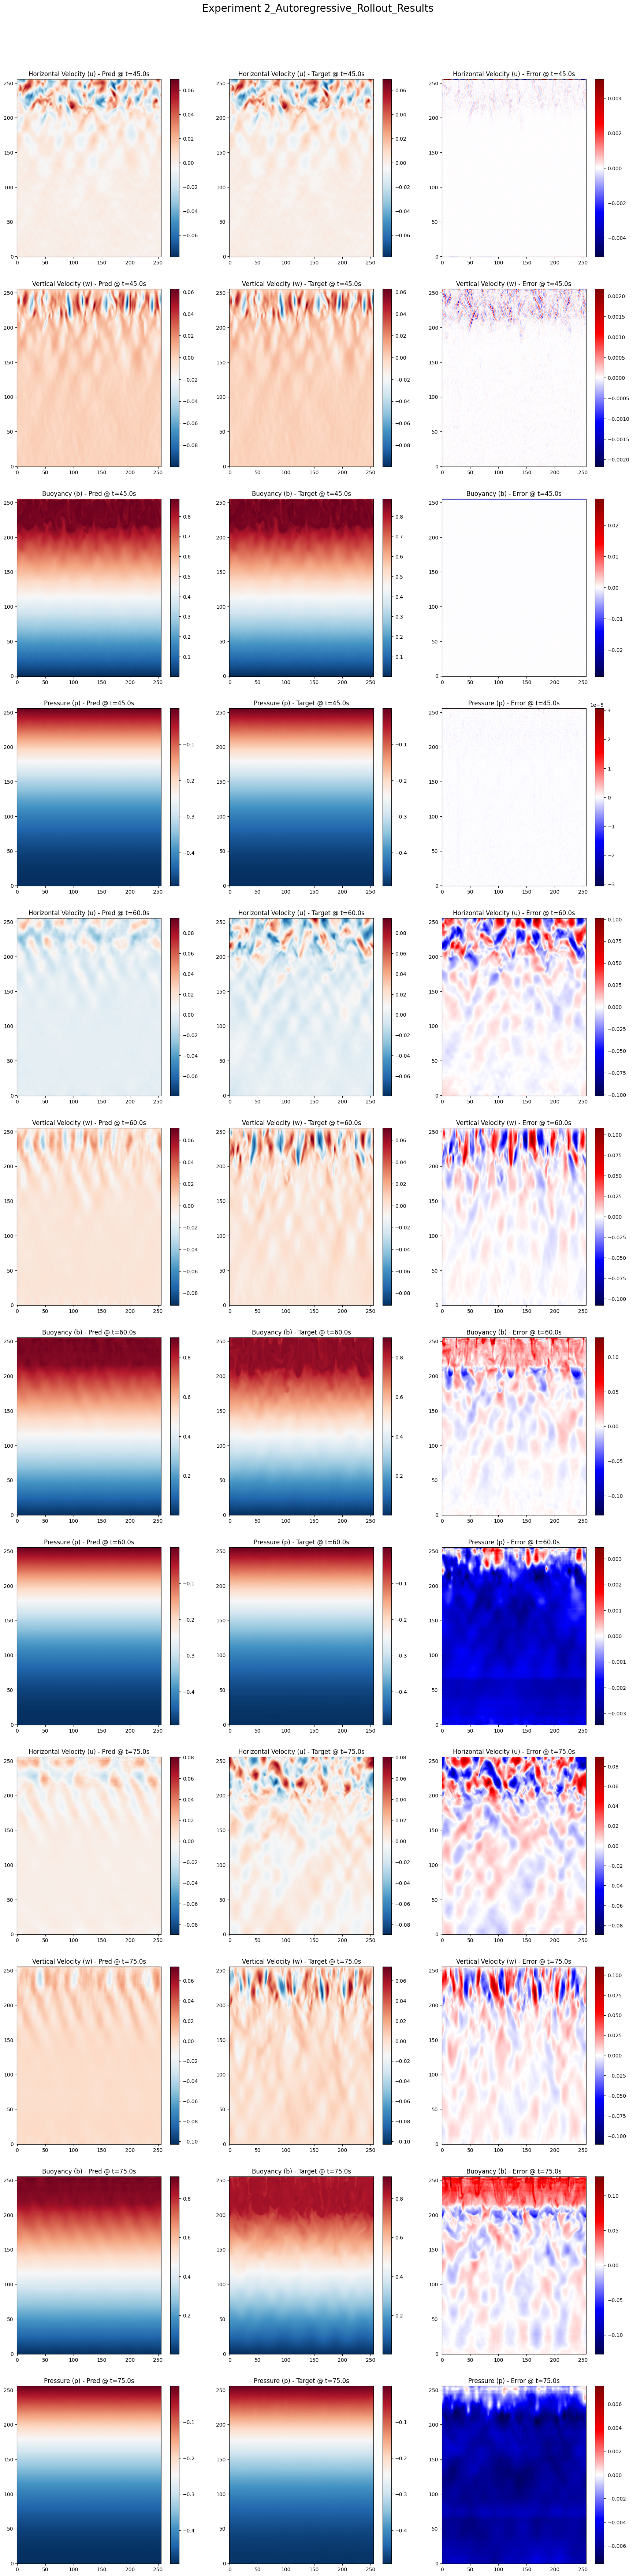

In [1]:
"""
PROMPT:
Now let's try to give one time step (keep current structure, like I can give as many time step I like, the model would initialize based on the list length, keep initial config. dict structure same) and predict many time time steps. So in target instead of one value it would be a list. Both train and target time steps' lists would be sorted and would have consistent del t. Example train time steps [30, 60], target time steps [90, 120]. 
Now I would like to conduct two different experiments:
	1. Train on train time steps, and first predict on target time step [0] and then take the predictions, take that into training, predict the target time step [1] and so on. Taking our example: train on [30, 60], predict on t=90, then again train on [30, 60, 90(predicted)] to predict t=120.
	2. Train on just train time step and predict on target time step [0], then take train time steps [1:] and append the target step just predicted, make this as input to the already trained model (on just the train time steps) and get the next target time step [1] 's output. Taking our example: train on [30, 60], completely stop training; predict on t=90, then give [60, 90(predicted)] data as input to predict t=120.

ADVICE: Be sure to clear cache and model after train and eval set, if the model would not be used again. No need to save model. Be sure to look for redundancy in GPU memory, otherwise we would run out of memory despite having actually sufficient memory for this task.

"""


#==================================
# BLOCK 1 - Configuration and Setup
#==================================

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import xarray as xr
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.fft import rfft2, irfft2, fftfreq
import time
import gc

# --- CONFIGURATION DICTIONARY ---
# Change all experimental parameters here.
CONFIG = {
    'model': {
        'modes1': 64,
        'modes2': 64,
        'width': 64,
        'n_vars': 4,  # u, w, b, p
        'n_layers': 4,
    },
    'data': {
        'train_times': [30, 60],  # Initial time steps for training
        'target_times': [90, 120, 150], # Time steps to predict sequentially
        'dt': 30.0,                  # Physical time difference between steps
    },
    'physics': {
        'kappa': 1e-6,
    },
    'training': {
        'epochs': 1600,
        'learning_rate': 1e-3,
        'weight_decay': 1e-4,
        'scheduler_pct_start': 0.1,
        'print_interval': 100, # Print progress every N epochs
    },
    'loss_weights': {
        'physics': 1.0,
        'data': 10.0,
        'bc': 50.0,
        'smooth': 0.01
    }
}

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

#==================================
# BLOCK 2 - Core FNO Components
#==================================

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels, self.out_channels, self.modes1, self.modes2 = in_channels, out_channels, modes1, modes2
        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
    def compl_mul2d(self, input, weights): return torch.einsum("bixy,ioxy->boxy", input, weights)
    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = rfft2(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        return irfft2(out_ft, s=(x.size(-2), x.size(-1)))

class FNOBlock(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, activation='gelu'):
        super(FNOBlock, self).__init__()
        self.conv = SpectralConv2d(in_channels, out_channels, modes1, modes2)
        self.w = nn.Conv2d(in_channels, out_channels, 1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.GELU() if activation == 'gelu' else nn.ReLU()
    def forward(self, x): return self.activation(self.bn(self.conv(x) + self.w(x)))

class MultiVariableFNO2d(nn.Module):
    def __init__(self, config, num_input_timesteps):
        super(MultiVariableFNO2d, self).__init__()
        self.modes1, self.modes2, self.width, self.n_vars, self.n_layers = (
            config['model']['modes1'], config['model']['modes2'], config['model']['width'],
            config['model']['n_vars'], config['model']['n_layers']
        )
        in_channels = self.n_vars * num_input_timesteps
        self.fc0 = nn.Sequential(nn.Conv2d(in_channels, self.width, 1), nn.GELU(), nn.Conv2d(self.width, self.width, 1))
        self.fno_blocks = nn.ModuleList([FNOBlock(self.width, self.width, self.modes1, self.modes2) for _ in range(self.n_layers)])
        self.fc1 = nn.Sequential(nn.Conv2d(self.width, 128, 1), nn.GELU(), nn.Conv2d(128, 64, 1), nn.GELU(), nn.Conv2d(64, self.n_vars, 1))
    def forward(self, x):
        x = self.fc0(x)
        for fno in self.fno_blocks: x = fno(x)
        return self.fc1(x)

#==================================
# BLOCK 3 - Data and Physics Helpers
#==================================

def extract_fields_at_time(ds, time_idx):
    data = ds.isel(time=time_idx)
    return {'u': data['u'].values, 'w': data['w'].values, 'b': data['b'].values, 'p_dyn': data['p_dyn'].values}

def interpolate_w_to_centers(w_field): return 0.5 * (w_field[:-1, :] + w_field[1:, :])
def interpolate_to_common_grid(field, target_shape=(256, 256)):
    if field.shape == target_shape: return field
    return F.interpolate(torch.from_numpy(field).float().unsqueeze(0).unsqueeze(0), size=target_shape, mode='bilinear', align_corners=True).squeeze().numpy()
def normalize_field(field):
    mean, std = np.mean(field), np.std(field) + 1e-8
    return (field - mean) / std, mean, std

def compute_derivatives_multi(fields, dx, dz):
    if fields.dim() == 3: fields = fields.unsqueeze(0)
    padded_x = F.pad(fields, (1, 1, 0, 0), mode='circular')
    df_dx = (padded_x[:, :, :, 2:] - padded_x[:, :, :, :-2]) / (2 * dx)
    df_dz = torch.zeros_like(fields)
    df_dz[:, :, 1:-1, :] = (fields[:, :, 2:, :] - fields[:, :, :-2, :]) / (2 * dz)
    df_dz[:, :, 0, :] = (fields[:, :, 1, :] - fields[:, :, 0, :]) / dz
    df_dz[:, :, -1, :] = (fields[:, :, -1, :] - fields[:, :, -2, :]) / dz
    return df_dx, df_dz

def physics_loss_multi(pred_norm, prev_states_norm, dx, dz, dt, kappa, norm_params):
    u_pred = pred_norm[:, 0] * norm_params['u'][1] + norm_params['u'][0]
    w_pred = pred_norm[:, 1] * norm_params['w'][1] + norm_params['w'][0]
    b_profile = torch.from_numpy(norm_params['b_profile']).float().to(device)
    b_pred_fluc = pred_norm[:, 2] * norm_params['b'][1] + norm_params['b'][0]
    b_pred = b_pred_fluc + b_profile
    p_profile = torch.from_numpy(norm_params['p_profile']).float().to(device)
    p_pred_fluc = pred_norm[:, 3] * norm_params['p'][1] + norm_params['p'][0]
    p_pred = p_pred_fluc + p_profile
    
    last_state = prev_states_norm[-1]
    u_last = torch.from_numpy(last_state['u']).float().to(device) * norm_params['u'][1] + norm_params['u'][0]
    w_last = torch.from_numpy(last_state['w']).float().to(device) * norm_params['w'][1] + norm_params['w'][0]
    b_last_fluc = torch.from_numpy(last_state['b']).float().to(device) * norm_params['b'][1] + norm_params['b'][0]
    b_last = b_last_fluc + b_profile
    
    all_fields = torch.stack([u_pred, w_pred, b_pred, p_pred], dim=1)
    df_dx, df_dz = compute_derivatives_multi(all_fields, dx, dz)
    
    du_dx, dw_dx, db_dx, dp_dx = [df_dx[:, i] for i in range(4)]
    du_dz, dw_dz, db_dz, dp_dz = [df_dz[:, i] for i in range(4)]
    
    d2u_dx2, _ = compute_derivatives_multi(du_dx.unsqueeze(1), dx, dz); _, d2u_dz2 = compute_derivatives_multi(du_dz.unsqueeze(1), dx, dz)
    d2w_dx2, _ = compute_derivatives_multi(dw_dx.unsqueeze(1), dx, dz); _, d2w_dz2 = compute_derivatives_multi(dw_dz.unsqueeze(1), dx, dz)
    d2b_dx2, _ = compute_derivatives_multi(db_dx.unsqueeze(1), dx, dz); _, d2b_dz2 = compute_derivatives_multi(db_dz.unsqueeze(1), dx, dz)
    
    du_dt, dw_dt, db_dt = (u_pred - u_last) / dt, (w_pred - w_last) / dt, (b_pred - b_last) / dt
    
    u_residual = du_dt + u_pred*du_dx.squeeze(1) + w_pred*du_dz.squeeze(1) + dp_dx.squeeze(1) - kappa*(d2u_dx2.squeeze(1) + d2u_dz2.squeeze(1))
    w_residual = dw_dt + u_pred*dw_dx.squeeze(1) + w_pred*dw_dz.squeeze(1) + dp_dz.squeeze(1) - kappa*(d2w_dx2.squeeze(1) + d2w_dz2.squeeze(1)) + b_pred
    continuity_residual = du_dx.squeeze(1) + dw_dz.squeeze(1)
    b_residual = db_dt + u_pred*db_dx.squeeze(1) + w_pred*db_dz.squeeze(1) - kappa*(d2b_dx2.squeeze(1) + d2b_dz2.squeeze(1))
    
    return torch.mean(u_residual**2) + torch.mean(w_residual**2) + torch.mean(continuity_residual**2) + torch.mean(b_residual**2)

def boundary_loss_multi(pred_norm, norm_params):
    u_pred = pred_norm[:, 0] * norm_params['u'][1] + norm_params['u'][0]
    w_pred = pred_norm[:, 1] * norm_params['w'][1] + norm_params['w'][0]
    b_profile = torch.from_numpy(norm_params['b_profile']).float().to(device)
    b_pred_fluc = pred_norm[:, 2] * norm_params['b'][1] + norm_params['b'][0]
    b_pred = b_pred_fluc + b_profile
    u_bc = torch.mean(u_pred[:, -1, :]**2) + torch.mean(u_pred[:, 0, :]**2)
    w_bc = torch.mean(w_pred[:, -1, :]**2) + torch.mean(w_pred[:, 0, :]**2)
    b_bc = torch.mean((b_pred[:, -1, :] - 0.5)**2) + torch.mean((b_pred[:, 0, :] - 0.0)**2)
    return u_bc + w_bc + b_bc

def smoothness_loss_multi(pred):
    tv_loss = 0
    for i in range(pred.shape[1]):
        field = pred[:, i]
        tv_loss += torch.mean(torch.abs(field[:, 1:, :] - field[:, :-1, :])) + torch.mean(torch.abs(field[:, :, 1:] - field[:, :, :-1]))
    return tv_loss

#==================================
# BLOCK 4 - Experiment Core Functions
#==================================

def prepare_data_and_tensors(ds, train_times, target_time, existing_norm_params=None):
    """Prepares normalized data and tensors for a given set of train/target times."""
    train_data = [extract_fields_at_time(ds, t) for t in train_times]
    target_data = extract_fields_at_time(ds, target_time)
    
    processed_train_data = []
    norm_params = existing_norm_params or {'u': None, 'w': None, 'b': None, 'p': None, 'b_profile': None, 'p_profile': None}
    
    for i, data in enumerate(train_data):
        w_centered = interpolate_w_to_centers(data['w'])
        u_interp = interpolate_to_common_grid(data['u'])
        b_interp = interpolate_to_common_grid(data['b'])
        p_interp = interpolate_to_common_grid(data['p_dyn'])
        
        if not existing_norm_params and i == 0:
            b_profile = np.mean(b_interp, axis=1, keepdims=True)
            p_profile = np.mean(p_interp, axis=1, keepdims=True)
            u_norm, u_mean, u_std = normalize_field(u_interp)
            w_norm, w_mean, w_std = normalize_field(w_centered)
            b_fluc_norm, b_fluc_mean, b_fluc_std = normalize_field(b_interp - b_profile)
            p_fluc_norm, p_fluc_mean, p_fluc_std = normalize_field(p_interp - p_profile)
            norm_params.update({'u':(u_mean, u_std), 'w':(w_mean, w_std), 'b':(b_fluc_mean, b_fluc_std), 'p':(p_fluc_mean, p_fluc_std), 'b_profile': b_profile, 'p_profile': p_profile})
            b_norm, p_norm = b_fluc_norm, p_fluc_norm
        else:
            u_norm = (u_interp - norm_params['u'][0]) / norm_params['u'][1]
            w_norm = (w_centered - norm_params['w'][0]) / norm_params['w'][1]
            b_norm = (b_interp - norm_params['b_profile'] - norm_params['b'][0]) / norm_params['b'][1]
            p_norm = (p_interp - norm_params['p_profile'] - norm_params['p'][0]) / norm_params['p'][1]

        processed_train_data.append({'u': u_norm, 'w': w_norm, 'b': b_norm, 'p': p_norm})

    target_b_norm = (interpolate_to_common_grid(target_data['b']) - norm_params['b_profile'] - norm_params['b'][0]) / norm_params['b'][1]
    target_p_norm = (interpolate_to_common_grid(target_data['p_dyn']) - norm_params['p_profile'] - norm_params['p'][0]) / norm_params['p'][1]
    target_u_norm = (interpolate_to_common_grid(target_data['u']) - norm_params['u'][0]) / norm_params['u'][1]
    target_w_norm = (interpolate_w_to_centers(target_data['w']) - norm_params['w'][0]) / norm_params['w'][1]
    
    input_channels = [d[k] for d in processed_train_data for k in ['u', 'w', 'b', 'p']]
    input_tensor = torch.FloatTensor(np.stack(input_channels, axis=0)).unsqueeze(0).to(device)
    target_tensor = torch.FloatTensor(np.stack([target_u_norm, target_w_norm, target_b_norm, target_p_norm], axis=0)).unsqueeze(0).to(device)
    
    return input_tensor, target_tensor, processed_train_data, norm_params

def train_model(config, input_tensor, target_tensor, processed_train_data, norm_params):
    """Trains a new FNO model and returns it."""
    model = MultiVariableFNO2d(config, num_input_timesteps=len(config['data']['train_times'])).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=config['training']['learning_rate'], weight_decay=config['training']['weight_decay'])
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config['training']['learning_rate'], epochs=config['training']['epochs'], steps_per_epoch=1, pct_start=config['training']['scheduler_pct_start'])
    loss_weights = config['loss_weights']
    
    model.train()
    best_loss = float('inf')
    print_interval = config['training']['print_interval']
    
    for epoch in range(config['training']['epochs']):
        optimizer.zero_grad()
        pred_norm = model(input_tensor)
        l_physics = physics_loss_multi(pred_norm, processed_train_data, dx, dz, config['data']['dt'], config['physics']['kappa'], norm_params)
        l_data = F.mse_loss(pred_norm, target_tensor)
        l_bc = boundary_loss_multi(pred_norm, norm_params)
        l_smooth = smoothness_loss_multi(pred_norm)
        total_loss = (loss_weights['physics'] * l_physics + loss_weights['data'] * l_data + loss_weights['bc'] * l_bc + loss_weights['smooth'] * l_smooth)
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        if total_loss.item() < best_loss:
            best_loss = total_loss.item()
            best_model_state = model.state_dict().copy()
        
        if epoch % print_interval == 0 or epoch == config['training']['epochs'] - 1:
            print(f"  Epoch {epoch}/{config['training']['epochs']} | Total Loss: {total_loss.item():.6f} | "
                  f"Physics: {l_physics.item():.6f} | Data: {l_data.item():.6f}")

    model.load_state_dict(best_model_state)
    return model

def plot_rollout_results(predictions, targets, title):
    """Plots a grid of predictions, targets, and errors for a multi-step rollout."""
    target_times = list(predictions.keys())
    n_steps = len(target_times)
    variables = ['u', 'w', 'b', 'p']
    n_vars = len(variables)
    
    # --- VISUALIZATION FIX: Create a 3-column grid with enough rows ---
    fig, axes = plt.subplots(n_vars * n_steps, 3, figsize=(18, 6 * n_vars * n_steps), squeeze=False)
    fig.suptitle(title, fontsize=20)
    
    var_names = ['Horizontal Velocity (u)', 'Vertical Velocity (w)', 'Buoyancy (b)', 'Pressure (p)']

    row_counter = 0
    for t in target_times:
        for i, var in enumerate(variables):
            pred, target = predictions[t][var], targets[t][var]
            vmin, vmax = min(pred.min(), target.min()), max(pred.max(), target.max())
            
            # Prediction
            ax_pred = axes[row_counter, 0]
            im1 = ax_pred.imshow(pred, aspect='auto', cmap='RdBu_r', vmin=vmin, vmax=vmax, origin='lower')
            ax_pred.set_title(f'{var_names[i]} - Pred @ t={t*0.5}s')
            fig.colorbar(im1, ax=ax_pred)
            
            # Target
            ax_target = axes[row_counter, 1]
            im2 = ax_target.imshow(target, aspect='auto', cmap='RdBu_r', vmin=vmin, vmax=vmax, origin='lower')
            ax_target.set_title(f'{var_names[i]} - Target @ t={t*0.5}s')
            fig.colorbar(im2, ax=ax_target)
            
            # Error
            ax_error = axes[row_counter, 2]
            diff = pred - target
            im3 = ax_error.imshow(diff, aspect='auto', cmap='seismic', vmin=-np.abs(diff).max(), vmax=np.abs(diff).max(), origin='lower')
            ax_error.set_title(f'{var_names[i]} - Error @ t={t*0.5}s')
            fig.colorbar(im3, ax=ax_error)
            
            row_counter += 1
            
    plt.tight_layout(pad=3.0, rect=[0, 0, 1, 0.97])
    plt.savefig(f"{title.replace(' ', '_')}.png", dpi=200)
    plt.show()

#==================================
# BLOCK 5 - EXPERIMENT 1: Re-training Rollout
#==================================

def run_experiment_1_retraining_rollout(config, ds):
    print("\n" + "="*50)
    print("RUNNING EXPERIMENT 1: Re-training Rollout")
    print("="*50)
    
    current_train_times = list(config['data']['train_times'])
    all_predictions = {}
    all_targets = {}
    
    _, _, _, norm_params = prepare_data_and_tensors(ds, current_train_times, config['data']['target_times'][0])
    initial_processed_data = prepare_data_and_tensors(ds, current_train_times, config['data']['target_times'][0], norm_params)[2]
    current_processed_data = list(initial_processed_data)

    for target_time in config['data']['target_times']:
        print(f"\n--- Training for target t={target_time*0.5}s ---")
        print(f"Using history from time indices: {current_train_times}")

        temp_config = config.copy()
        temp_config['data'] = config['data'].copy()
        temp_config['data']['train_times'] = current_train_times
        
        input_channels = [d[k] for d in current_processed_data for k in ['u', 'w', 'b', 'p']]
        input_tensor = torch.FloatTensor(np.stack(input_channels, axis=0)).unsqueeze(0).to(device)
        _, target_tensor, _, _ = prepare_data_and_tensors(ds, current_train_times, target_time, norm_params)

        model = train_model(temp_config, input_tensor, target_tensor, current_processed_data, norm_params)
        
        model.eval()
        with torch.no_grad():
            pred_norm = model(input_tensor).squeeze(0).cpu().numpy()
        
        pred = {
            'u': pred_norm[0] * norm_params['u'][1] + norm_params['u'][0],
            'w': pred_norm[1] * norm_params['w'][1] + norm_params['w'][0],
            'b': (pred_norm[2] * norm_params['b'][1] + norm_params['b'][0]) + norm_params['b_profile'],
            'p': (pred_norm[3] * norm_params['p'][1] + norm_params['p'][0]) + norm_params['p_profile']
        }
        all_predictions[target_time] = pred
        
        target_data_step = extract_fields_at_time(ds, target_time)
        all_targets[target_time] = {
            'u': interpolate_to_common_grid(target_data_step['u']),
            'w': interpolate_w_to_centers(target_data_step['w']),
            'b': interpolate_to_common_grid(target_data_step['b']),
            'p': interpolate_to_common_grid(target_data_step['p_dyn'])
        }

        new_processed_data = {'u': pred_norm[0], 'w': pred_norm[1], 'b': pred_norm[2], 'p': pred_norm[3]}
        current_processed_data.append(new_processed_data)
        current_train_times.append(target_time)
        
        del model, input_tensor, target_tensor
        torch.cuda.empty_cache()
        gc.collect()

    plot_rollout_results(all_predictions, all_targets, "Experiment 1_Re-training_Rollout_Results")

#==================================
# BLOCK 6 - EXPERIMENT 2: Autoregressive Rollout
#==================================

def run_experiment_2_autoregressive_rollout(config, ds):
    print("\n" + "="*50)
    print("RUNNING EXPERIMENT 2: Autoregressive Rollout")
    print("="*50)
    
    initial_train_times = config['data']['train_times']
    
    print(f"--- Training a single model on time indices: {initial_train_times} ---")
    input_tensor, target_tensor, processed_train_data, norm_params = prepare_data_and_tensors(ds, initial_train_times, config['data']['target_times'][0])
    model = train_model(config, input_tensor, target_tensor, processed_train_data, norm_params)
    
    current_input_data_norm = list(processed_train_data)
    all_predictions = {}
    all_targets = {}
    
    model.eval()
    with torch.no_grad():
        for target_time in config['data']['target_times']:
            print(f"--- Autoregressively predicting t={target_time*0.5}s ---")
            
            input_channels = [d[k] for d in current_input_data_norm for k in ['u', 'w', 'b', 'p']]
            rollout_input_tensor = torch.FloatTensor(np.stack(input_channels, axis=0)).unsqueeze(0).to(device)
            
            pred_norm_tensor = model(rollout_input_tensor).squeeze(0)
            pred_norm = pred_norm_tensor.cpu().numpy()
            
            pred = {
                'u': pred_norm[0] * norm_params['u'][1] + norm_params['u'][0],
                'w': pred_norm[1] * norm_params['w'][1] + norm_params['w'][0],
                'b': (pred_norm[2] * norm_params['b'][1] + norm_params['b'][0]) + norm_params['b_profile'],
                'p': (pred_norm[3] * norm_params['p'][1] + norm_params['p'][0]) + norm_params['p_profile']
            }
            all_predictions[target_time] = pred
            
            target_data_step = extract_fields_at_time(ds, target_time)
            all_targets[target_time] = {
                'u': interpolate_to_common_grid(target_data_step['u']),
                'w': interpolate_w_to_centers(target_data_step['w']),
                'b': interpolate_to_common_grid(target_data_step['b']),
                'p': interpolate_to_common_grid(target_data_step['p_dyn'])
            }
            
            new_processed_data = {'u': pred_norm[0], 'w': pred_norm[1], 'b': pred_norm[2], 'p': pred_norm[3]}
            current_input_data_norm = current_input_data_norm[1:] + [new_processed_data]
            
    plot_rollout_results(all_predictions, all_targets, "Experiment 2_Autoregressive_Rollout_Results")

    del model
    torch.cuda.empty_cache()
    gc.collect()

#==================================
# BLOCK 7 - Main Execution
#==================================

if __name__ == '__main__':
    ds = xr.open_dataset('/kaggle/input/pr1-rbc-sim-data/RBC_Output.nc')
    x_coords, z_coords = ds.x_caa.values, ds.z_aac.values
    dx, dz = float(x_coords[1] - x_coords[0]), float(z_coords[1] - z_coords[0])
    
    run_experiment_1_retraining_rollout(CONFIG, ds)
    run_experiment_2_autoregressive_rollout(CONFIG, ds)
